# Arbitrary Transformations

# Li Kailang FDQAOR

Due No Due Date Points 0 Submitting a file upload File Types py and ipynb
Download 场景 5。

Estimate rigid body transformations based on Euler angles [Roll, Pitch, Yaw] and translation vector [x, y, z]

Estimate Euler angles and translation that create rigid body transformation that transforms the 3D point cloud from the lidar coordinate system to an imaginary camera coordinate system.

Lidar coordinate system:

Camera coordinate system:

Lidar_2_cam.png

Add to the transformations that you estimated in the previous step an additional rigid body transformation that will act as a viewer (eg: see at 0, 45 and 90 deg in azimuth)

Construct an arbitrary 2D projection matrix to project to 2D plane :

Fx: 800
Fy: 800
Height: 720
Width: 1920
PPX: Height / 2 (pixel position)
PPY: Width / 2 (pixel position)
Project onto a black image using hsv colormap:
cmap = plt.cm.get_cmap('hsv ', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :-1] * 255

1. 加载 Scene 5 的点云数据

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import numpy as np

# 加载 bin 文件
def load_point_cloud_from_bin(bin_path):
    point_cloud = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)  # x, y, z, intensity
    return point_cloud[:, :3], point_cloud[:, 3]  # 返回xyz坐标和强度

# 替换为实际路径
bin_file_path = '/content/drive/MyDrive/3d point could/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data/0000000000.bin'
points, intensity = load_point_cloud_from_bin(bin_file_path)
x, y, z = points[:, 0], points[:, 1], points[:, 2]

print("点云数据加载完成")


点云数据加载完成


2. 构建刚体变换

In [4]:
import math

# 欧拉角和平移向量（请根据实际任务修改值）
roll, pitch, yaw = np.deg2rad([10, 20, 30])  # 角度转弧度
tx, ty, tz = 5, 2, 3  # 平移向量

# 计算旋转矩阵
def euler_to_rotation_matrix(roll, pitch, yaw):
    R_x = np.array([[1, 0, 0],
                    [0, math.cos(roll), -math.sin(roll)],
                    [0, math.sin(roll), math.cos(roll)]])
    R_y = np.array([[math.cos(pitch), 0, math.sin(pitch)],
                    [0, 1, 0],
                    [-math.sin(pitch), 0, math.cos(pitch)]])
    R_z = np.array([[math.cos(yaw), -math.sin(yaw), 0],
                    [math.sin(yaw), math.cos(yaw), 0],
                    [0, 0, 1]])
    return R_z @ R_y @ R_x

R = euler_to_rotation_matrix(roll, pitch, yaw)
T = np.array([tx, ty, tz])

# 构建刚体变换
def transform_points(points, R, T):
    return (R @ points.T).T + T

transformed_points = transform_points(points, R, T)
print("刚体变换完成")


刚体变换完成


3. 添加额外变换作为视角调整

In [6]:
# 添加额外变换模拟视角调整
yaw_view = np.deg2rad(45)  # 视角方位角，例如 45 度
R_view = euler_to_rotation_matrix(0, 0, yaw_view)  # 仅旋转绕Z轴（方位角）
transformed_points_view = transform_points(transformed_points, R_view, np.array([0, 0, 0]))


4. 投影到2D平面

In [7]:
# 投影参数
fx = 800
fy = 800
height = 720
width = 1920
ppx = width / 2
ppy = height / 2

# 投影矩阵
projection_matrix = np.array([[fx, 0, ppx, 0],
                               [0, fy, ppy, 0],
                               [0, 0, 1, 0]])

# 添加一列1表示齐次坐标
points_homogeneous = np.hstack((transformed_points_view, np.ones((transformed_points_view.shape[0], 1))))

# 投影到2D
points_2d = (projection_matrix @ points_homogeneous.T).T
points_2d[:, 0] /= points_2d[:, 2]
points_2d[:, 1] /= points_2d[:, 2]

# 过滤有效点
valid_idx = (points_2d[:, 0] >= 0) & (points_2d[:, 0] < width) & \
            (points_2d[:, 1] >= 0) & (points_2d[:, 1] < height)
points_2d = points_2d[valid_idx]
intensity = intensity[valid_idx]


5. 使用 HSV colormap 进行可视化


<ipython-input-9-0fd6287705bc>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 256)


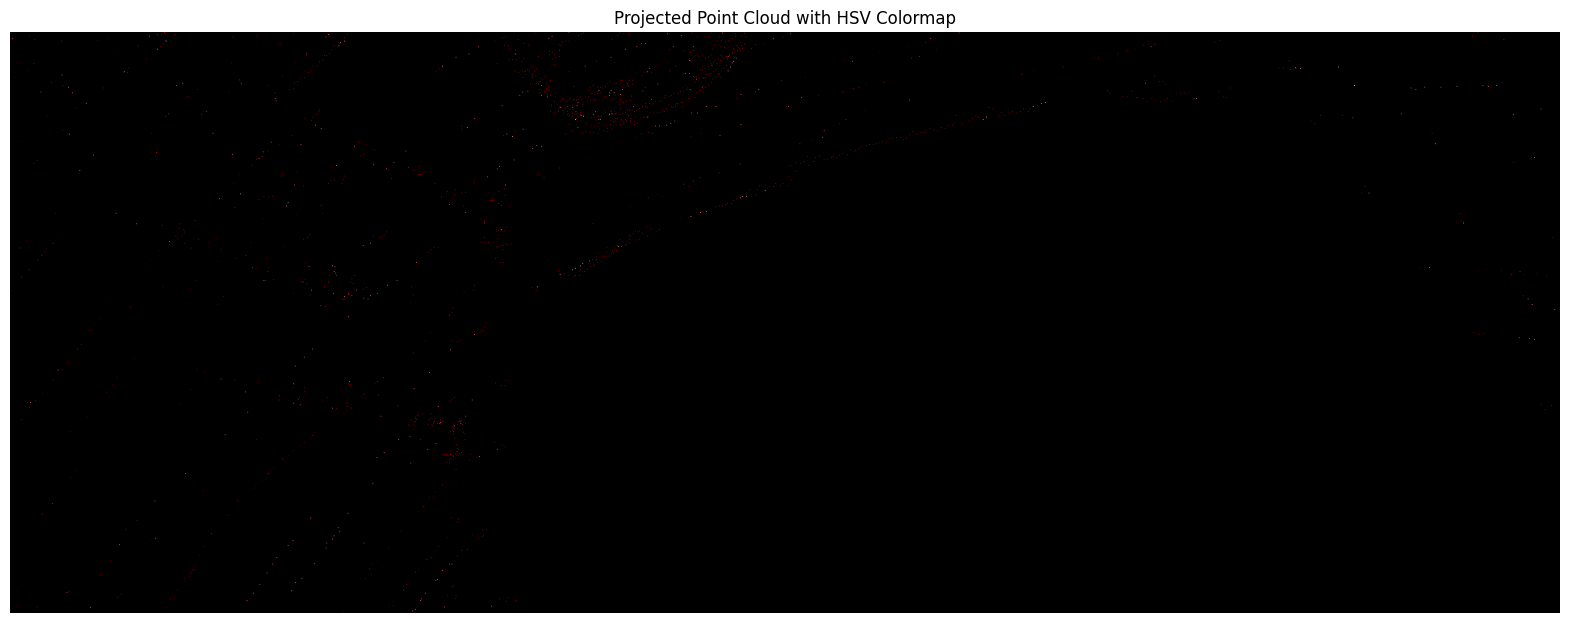

In [9]:
import matplotlib.pyplot as plt
import cv2

# 创建黑色图像
image = np.zeros((height, width, 3), dtype=np.uint8)

# 使用HSV颜色映射
cmap = plt.cm.get_cmap('hsv', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :-1] * 255

# 将强度映射到颜色
intensity_normalized = (intensity / np.max(intensity) * 255).astype(np.int32)
colors = cmap[intensity_normalized]

# 在图像上绘制点
for i in range(points_2d.shape[0]):
    x, y = int(points_2d[i, 0]), int(points_2d[i, 1])
    if 0 <= x < width and 0 <= y < height:
        image[y, x] = colors[intensity_normalized[i]]

# 转换为RGB格式并显示
image_rgb = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
plt.figure(figsize=(20, 20))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Projected Point Cloud with HSV Colormap')
plt.show()
